In [1]:
# adding habitat and mask into analysis
# how to input multiple values using click
# all parts of uniform design called from main function
# how to do pop up for suggested number of sample sites? - suggest and enter later in analysis

from osgeo import gdal
import numpy as np
from scipy import ndimage
import pandas as pd
from matplotlib import pyplot as plt
from random import randint


def get_file_info(file_path):
    '''
    Function which extracts a geotiff file as numpy array, and saves geographic projection information
    input:
        file_path: (str) Path to the file
    output:
        file_map: (np.array) The extracted map
        nbins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        GeoT: The geographic transform used to project the map
        auth_code: The authority code matching the projection
    '''
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    GeoT = file_raw.GetGeoTransform()
    res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, prj_info

def extract_raster(tif_path):
    """
    Extract array from satellite image of study location.
    *Same as get_file_info but without geo-information
    INPUTS:
        file_path: (string) Relative path to .tif file
    OUTPUTS:
        file_map: (.npy array) 2D numpy array of study site
    """
    tif_raw = gdal.Open(tif_path)
    return tif_raw.ReadAsArray()

def discretize_metric(metric, mask, n_bins):
    """
    Convert continuous metrics to discrete, based on the specified number of bins
    INPUTS:
        metric: (np.array) fragmentation metric map
        mask: (np.array) binary mask showing locations which should not be sampled
        n_bins: (int) number of intervals the range of the metric should be divided into
    OUTPUTS:
        metric_bin: (np.array) the binned fragmentation metric
        ids: (list) the unique id values assigned to each bin
        breaks: (list) the intervals where the range of the metric was split
    """
    imheight, imwidth = metric.shape
    # Mask out invalid areas of metric (numpy masked array function reads one as invalid, so invert mask)
    metric_mask = np.ma.masked_array(metric, mask=(1-mask))
    # Break range of unmasked metric values into 'n_bins' intervals
    hist, breaks = np.histogram(metric_mask.compressed(), bins=n_bins)
    # Each bin a unique integer ID
    ids = np.arange(0, n_bins)
    ones = np.ones((imheight, imwidth))
    metric_bin = np.zeros((imheight, imwidth))
    # Loop through ID's and convert all values in each bin to corresponding id
    for ID in ids:
        # Closed on the lower bound, open on the top
        lower_lim = np.where(ones, metric_mask >= breaks[ID], 0)
        upper_lim = np.where(ones, metric_mask < breaks[ID+1], 0)
        # Make the last interval closed at the upper bound
        if ID == n_bins-1:
            upper_lim = np.where(ones, metric_mask <= breaks[ID+1], 0)
        metric_bin += lower_lim*upper_lim*ID
    return metric_bin, ids, breaks


def build_df(bin_ids):
    """Create a dataframe of all combinations of IDs"""
    # Create array of all combinations
    id_mesh = np.meshgrid(*bin_ids)
    # Convert to dataframe, each row represents a unique combination of the ID's
    combo_df = pd.DataFrame([ids.flatten() for ids in id_mesh]).T
    return combo_df


# def bin_metrics(input_metrics, mask, nbins):
#     """Bin all input metric arrays into discrete ID arrays, and create a dataframe of all the
#     unique combinations of these IDs"""
#     binned_metrics = []
#     bin_ids = []
#     bin_breaks = []
#     # Generate a binned version of all input metric arrays
#     for i in range(len(input_metrics)-1):
#         metric_bin, ids, breaks = discretize_metric(input_metrics[i + 1], mask, nbins[i + 1])
#         binned_metrics.append(metric_bin)  # Save all new (discretized) metric arrays
#         bin_ids.append(ids)  # Save the list of all IDs present for each array
#         bin_breaks.append(breaks)  # Save the bin breaks for each metric
#     # Generate dataframe of all combinations of IDs between the input metric arrays
#     combo_df = build_df(bin_ids)
#     return binned_metrics, combo_df, bin_breaks

def bin_metrics(metric_list, mask, bins_list):
    """Bin all input metric arrays into discrete ID arrays, and create a dataframe of all the
    unique combinations of these IDs"""
    binned_metrics = []
    bin_ids = []
    bin_breaks = []
    # Generate a binned version of all input metric arrays
    for i in range(len(metric_list)):
        metric_bin, ids, breaks = discretize_metric(metric_list[i], mask, bins_list[i])
        binned_metrics.append(metric_bin)  # Save all new (discretized) metric arrays
        bin_ids.append(ids)  # Save the list of all IDs present for each array
        bin_breaks.append(breaks)  # Save the bin breaks for each metric
    # Generate dataframe of all combinations of IDs between the input metric arrays
    combo_df = build_df(bin_ids)
    return binned_metrics, combo_df, bin_breaks


In [25]:
from utils import get_file_info, plot_uniform, save_uniform, extract_raster
import os
import numpy as np

habmap_path = 'raw/HabitatMap.tif'
metrics = ['raw/DistanceToEdgeLog2.tif', 'raw/FragmentAreaLog10.tif']
bins = [10, 8]
mask_path = 'raw/InvalidAreasMask.tif'
# mask_path = None
nsp = 5

# get geo info and habitat map from tif file
habmap, nbins, res, GeoT, auth_code = get_file_info(habmap_path)

if mask_path is not None:
    mask = extract_raster(mask_path)
else:
    mask = np.ones((habmap.shape[0], habmap.shape[1]))

metric_list = [habmap]
bins_list = [nbins]

### when to add in the habitat map?
### save as numpy array rather than lists (all same dimension anyway)
for i in range(len(metrics)):
    metric = extract_raster(metrics[i])
    metric_list.append(metric)
    bins_list.append(bins[i])

binned_metrics, combo_df, bin_breaks = bin_metrics(metric_list, mask, bins_list)

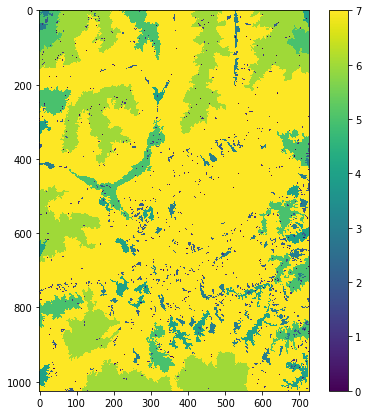

In [6]:
plt.figure(figsize=(7, 7))
plt.imshow(binned_metrics[2])
plt.colorbar()
plt.show()

In [26]:
combo_df.head()

,0,1,2
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4


In [28]:
def generate_all_layers(binned_metrics, mask, combo_df):
    """Create single combined ID array and calculate the optimum number of sample sites in each ID """
    imheight, imwidth = mask.shape
    combo_num = len(combo_df)
    # create 3d array to store ID combo layers in
    all_layers = np.zeros((combo_num, imheight, imwidth))
    counts = []
    # Iterate through all unique ID combinations
    for i in range(combo_num):
        im_layer = np.ones((imheight, imwidth))
        for j in range(len(binned_metrics)):
            # Convert selected ID to binary for each metric, and multiply together to see where
            # combinations are in the landscape image
            im_layer = np.where(binned_metrics[j] == combo_df.iloc[i][j], 1, 0) * im_layer
        # Make sure invalid areas are set as zero
        layer_mask = im_layer * mask
        counts.append(np.sum(layer_mask))  # Store the number of pixels in each unique combo layer
        all_layers[i, :, :] = layer_mask  # Save combo Id layer in 3d array
    combo_df['n_pixels'] = counts
    return all_layers, combo_df


all_layers, combo_df = generate_all_layers(binned_metrics, mask, combo_df)


In [37]:
all_layers.shape

(160, 1025, 727)

In [36]:
combo_df[:20]

,0,1,2,n_pixels
0,0,0,0,0.0
1,0,0,1,0.0
2,0,0,2,0.0
3,0,0,3,0.0
4,0,0,4,0.0
5,0,0,5,0.0
6,0,0,6,0.0
7,0,0,7,0.0
8,1,0,0,1177.0
9,1,0,1,3189.0


In [ ]:
ID_df = combo_df[combo_df.Counts != 0]  # remove empty bins to create ID dataframe
s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
ID_df = ID_df[ID_df.Counts >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
s_opt = np.float(nsp) / len(ID_df)

In [18]:
s_opt

0.09433962264150944

In [19]:
save_path = 'test'

def generate_ID_im(all_layers, ID_df, nsp, savepath):
    imdepth, imheight, imwidth = all_layers.shape
    ID_im = np.zeros((imheight, imwidth))
    store_masks = np.zeros((len(ID_df), imheight, imwidth))
    counter = 0;
    unique_IDs = []
    for k in ID_df.index.values:
        store_masks[counter, :, :] = all_layers[k, :, :]
        ID_im += all_layers[k, :, :] * (counter + 1)
        unique_IDs.append(counter + 1)
        counter += 1
    # Save an ID image for adapted uniform designs
    # np.save("{0}/{1}Site_Uniform_IDim".format(savepath, nsp), ID_im)
    return store_masks, ID_im, unique_IDs

store_masks, ID_im, unique_IDs = generate_ID_im(all_layers, ID_df, nsp, save_path)
print(unique_IDs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


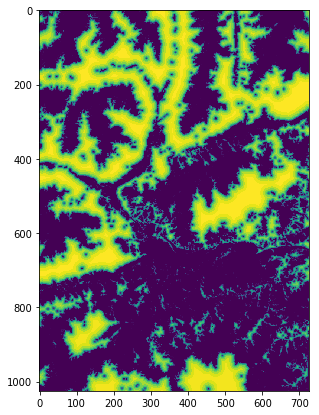

In [20]:
plt.figure(figsize=(7, 7))
plt.imshow(ID_im)
plt.show()

In [21]:
def generate_id_list(unique_IDs, s_opt, nsp, ID_df):
    id_rep = np.repeat(unique_IDs, np.floor(s_opt))
    print(s_opt, np.floor(s_opt), len(id_rep))
    diff = nsp - len(id_rep)
    if diff>0:
        print('difference of {}'.format(diff))
        extra_ids = np.random.choice(unique_IDs, diff, replace=False)
        id_rep = np.hstack([id_rep, extra_ids])
        print(id_rep)
    elif diff<0:
        print('error')
    else:
        print('{} sample sites requested, {} sampled'.format(nsp, len(id_rep)))
    # If nsp is less than the number of IDs (i.e one or less sample per ID),
    # then create a reduced dataframe
    if len(id_rep) < len(unique_IDs):
        print('creating reduced dataframe')
#         id_mix.sort()
        df_ids = [i - 1 for i in id_rep]
        ID_df_red = ID_df.iloc[df_ids, :].copy(deep=True)
    ID_df_red['Freq'] = np.unique(id_rep, return_counts=True)[1]
    id_mix = np.random.permutation(id_rep)
    return id_mix, ID_df_red

# def generate_id_list(unique_IDs, s_opt, nsp, ID_df):
#     """Create a list where each unique ID is repeated by s_opt"""
#     id_rep = np.repeat(unique_IDs, np.floor(s_opt))  
#     # If there is a difference in the number of sample sites and the number of elements
#     # in id_rep then add extras randomly from the list of IDs, without replacement
#     diff = nsp-len(id_rep)
#     while diff >= len(unique_IDs):
#         id_rep = np.hstack([id_rep, unique_IDs])
#         diff = nsp-len(id_rep)        
#     extra_sites = np.random.choice(unique_IDs, nsp-len(id_rep), replace=False) 
#     id_list = np.hstack([id_rep, extra_sites]) # Now list of length nsp
#     # Randomly permute list
#     id_mix = np.random.permutation(id_list)
#     # If nsp is less than the number of IDs (i.e one or less sample per ID),
#     # then create a reduced dataframe 
#     if len(id_mix) < len(unique_IDs):
#         id_mix.sort()
#         ID_df = ID_df.iloc[id_mix]    
#     ID_df['Freq'] = np.unique(id_mix, return_counts=True)[1]
#     return id_mix, ID_df

In [22]:
id_mix, ID_df = generate_id_list(unique_IDs, s_opt, nsp, ID_df)

0.09433962264150944 0.0 0
difference of 5
[24 44 46 49 53]
creating reduced dataframe


In [47]:
## replace the store_masks with the ID_im. Create mask in each loop by converting all ID values to one, zeros elsewhere
def generate_uniform_design(id_mix, ID_im):

    imheight, imwidth = ID_im.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    x_vals = []
    y_vals = []
    loop_count = 0

    for i in id_mix:
        
        loop_count += 1
        print('Plotting site {}, id number {}'.format(loop_count, i))

        # Select binary map relating to selected ID
        mask_ID = np.where(ID_im==i, 1, 0)
        # Mask out any regions of EDT not in ID
        layer = mask_ID * dist_im

        # Extract coords of pixels with maximum distance value and choose one at random
        dist_mx = list(zip(*np.where(layer == layer.max())))
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]
        
        # Save coordinates
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Add selected site to sites array as 0 (feature pixel)
        sites[x, y] = 0

        # Compute EDT from all placed sites
        dist_im = ndimage.distance_transform_edt(sites)

    print('Uniform sample design complete!')

    return x_vals, y_vals

In [48]:
x_unif, y_unif = generate_uniform_design(id_mix, ID_im)

Plotting site 1, id number 27
Plotting site 2, id number 44
Plotting site 3, id number 9
Plotting site 4, id number 11
Plotting site 5, id number 12
Plotting site 6, id number 39
Plotting site 7, id number 9
Plotting site 8, id number 46
Plotting site 9, id number 28
Plotting site 10, id number 17
Plotting site 11, id number 44
Plotting site 12, id number 13
Plotting site 13, id number 41
Plotting site 14, id number 42
Plotting site 15, id number 26
Plotting site 16, id number 41
Plotting site 17, id number 6
Plotting site 18, id number 37
Plotting site 19, id number 49
Plotting site 20, id number 27
Plotting site 21, id number 2
Plotting site 22, id number 3
Plotting site 23, id number 17
Plotting site 24, id number 40
Plotting site 25, id number 19
Plotting site 26, id number 51
Plotting site 27, id number 25
Plotting site 28, id number 12
Plotting site 29, id number 48
Plotting site 30, id number 19
Plotting site 31, id number 11
Plotting site 32, id number 32
Plotting site 33, id n

Plotting site 263, id number 4
Plotting site 264, id number 34
Plotting site 265, id number 6
Plotting site 266, id number 41
Plotting site 267, id number 33
Plotting site 268, id number 10
Plotting site 269, id number 47
Plotting site 270, id number 50
Plotting site 271, id number 11
Plotting site 272, id number 40
Plotting site 273, id number 32
Plotting site 274, id number 47
Plotting site 275, id number 10
Plotting site 276, id number 47
Plotting site 277, id number 49
Plotting site 278, id number 34
Plotting site 279, id number 43
Plotting site 280, id number 19
Plotting site 281, id number 4
Plotting site 282, id number 1
Plotting site 283, id number 4
Plotting site 284, id number 18
Plotting site 285, id number 17
Plotting site 286, id number 4
Plotting site 287, id number 14
Plotting site 288, id number 5
Plotting site 289, id number 31
Plotting site 290, id number 3
Plotting site 291, id number 16
Plotting site 292, id number 41
Plotting site 293, id number 16
Plotting site 29

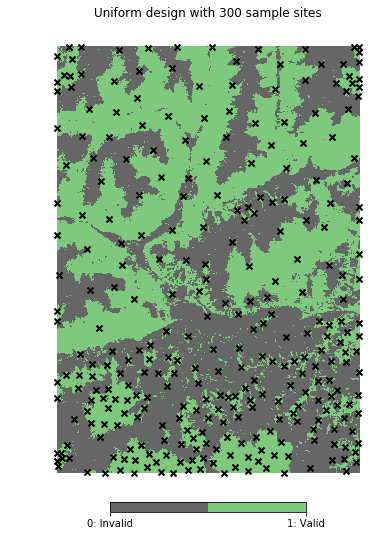

In [49]:
mask_path = 'raw/InvalidAreasMask.tif'
mask = extract_raster(mask_path)

plt.figure(figsize=(7, 9))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
# plt.imshow(ID_im)
plt.title('{} design with {} sample sites'.format('Uniform', len(x_unif)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_unif, x_unif, c='black', marker='x', linewidth=2)
# plt.savefig('{}/{}_{}Site_Uniform_Plot.tif'.format(directory, ts, nsp))
plt.show()